In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data = "Data_Train.xlsx"

# Data Wrangling and Feature Engineering

In [3]:
def wrangle(data):
    df = pd.read_excel(data)
    
    df = df.dropna()
    
    df['Travel_day'] = pd.to_datetime(df['Date_of_Journey'], format="%d/%m/%Y").dt.day
    df['Travel_month'] = pd.to_datetime(df['Date_of_Journey'], format="%d/%m/%Y").dt.month
    df = df.drop(columns='Date_of_Journey')
    
    df['Dep_hour'] = pd.to_datetime(df['Dep_Time'], format='%H:%M').dt.hour
    df['Dep_min'] = pd.to_datetime(df['Dep_Time'], format='%H:%M').dt.minute
    df = df.drop(columns='Dep_Time')
    
    df['Arr_hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
    df['Arr_min'] = pd.to_datetime(df['Arrival_Time']).dt.minute
    df = df.drop(columns='Arrival_Time')
    
    def duration_hour(duration):
        hour = []
        minute= []
        for data in duration:
            if "h" in data and "m" in data:
                part = data.split(' ')
                hour.append(part[0])
                minute.append(part[1])
            elif "h" in data and "m" not in data:
                hour.append(data)
                minute.append("0m")
            elif "h" not in data and "m" in data:
                hour.append("0h")
                minute.append(data)

        return hour, minute
    df["dur_hour"], df['dur_minutes'] = duration_hour(df["Duration"])
    df = df.drop(columns="Duration")
    
    df['durr_hour'] = df["dur_hour"].str.rstrip('h').astype(int)
    df['durr_minute'] = df["dur_minutes"].str.rstrip('m').astype(int)
    df = df.drop(columns=['dur_hour','dur_minutes'])
    
    df["Total_Stops"].replace({'non-stop':0, '1 stop':1, '2 stops':2, '3 stops':3, '4 stops':4}, inplace=True)
    df=df.drop(columns=['Route','Additional_Info'])
    
    return df

In [4]:
df = wrangle(data)

C:\Users\Asad Ali Akhtar\AppData\Local\Temp\ipykernel_12932\577461811.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Arr_hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
C:\Users\Asad Ali Akhtar\AppData\Local\Temp\ipykernel_12932\577461811.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Arr_min'] = pd.to_datetime(df['Arrival_Time']).dt.minute


In [5]:
df.head()

,Airline,Source,Destination,Total_Stops,Price,Travel_day,Travel_month,Dep_hour,Dep_min,Arr_hour,Arr_min,durr_hour,durr_minute
0,IndiGo,Banglore,New Delhi,0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1,13302,1,3,16,50,21,35,4,45


# Feature Exploration

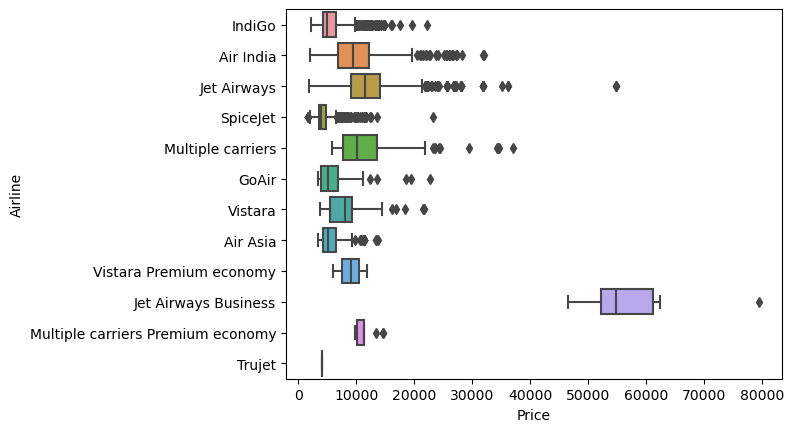

In [6]:
sns.boxplot(x=df['Price'],y=df['Airline']);

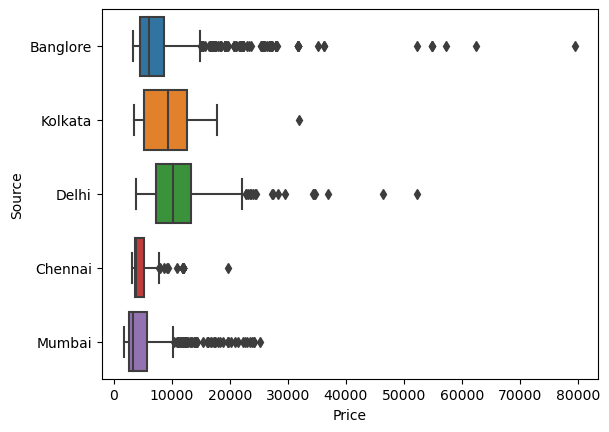

In [7]:
sns.boxplot(x=df['Price'],y=df['Source']);

In [8]:
#seperating object type features form int & float, to make a heat map.As heatmap only takes numeric values as input
map_ = df.iloc[:,3:]

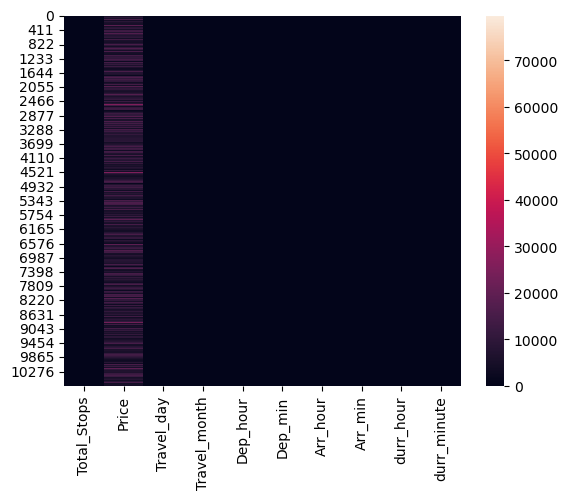

In [9]:
sns.heatmap(map_);

# Spliting Data

In [10]:
X = df.drop(columns='Price')
y = df['Price']

# Important Features Extraction

In [11]:
imp_feat = make_pipeline(OneHotEncoder(use_cat_names=True), ExtraTreesRegressor())
imp_feat.fit(X,y)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Airline', 'Source', 'Destination'],
                               use_cat_names=True)),
                ('extratreesregressor', ExtraTreesRegressor())])

In [12]:
features = imp_feat.named_steps['onehotencoder'].get_feature_names()
importance = imp_feat.named_steps['extratreesregressor'].feature_importances_
feature_imp = pd.Series(np.exp(importance), index=features).sort_values()
feature_imp.head()

Airline_Vistara Premium economy              1.000091
Airline_Trujet                               1.000106
Destination_Kolkata                          1.000395
Source_Chennai                               1.000546
Airline_Multiple carriers Premium economy    1.000801
dtype: float64

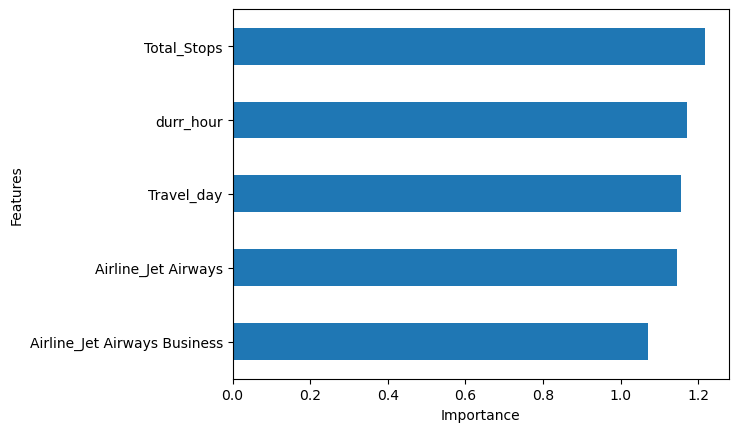

In [13]:
feature_imp.tail().plot(kind="barh")
plt.xlabel("Importance")
plt.ylabel("Features");

# Spliting Data further

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2)

# Baseline Model

In [15]:
y_mean = y.mean()
print("Mean absolute Price:", round(y_mean,2))
y_baseline = len(y) * [y_mean]
print("Baseline MAE:", mean_absolute_error(y, y_baseline))

Mean absolute Price: 9087.21
Baseline MAE: 3655.844715930548


# Model Building

In [16]:
model = make_pipeline(OneHotEncoder(use_cat_names=True), LinearRegression())
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Airline', 'Source', 'Destination'],
                               use_cat_names=True)),
                ('linearregression', LinearRegression())])

In [17]:
prediction = model.predict(X_test)

In [18]:
print("Model MAE:", mean_absolute_error(y_test, prediction))

Model MAE: 1972.9023675128685


As our Model MAE beats the Baseline MAE, Our model is performing well!

C:\Users\Asad Ali Akhtar\AppData\Local\Temp\ipykernel_12932\3354484248.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-prediction)


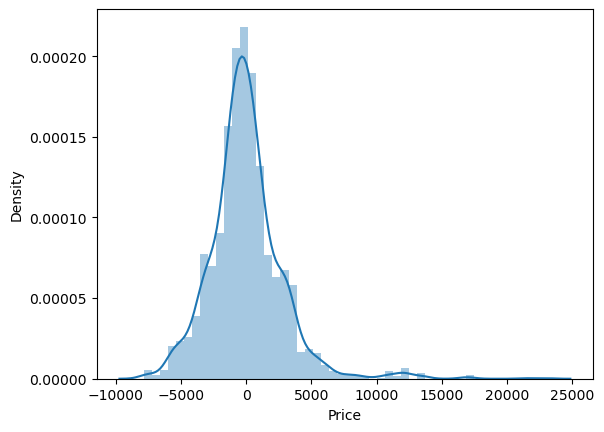

In [19]:
sns.distplot(y_test-prediction)
plt.show()

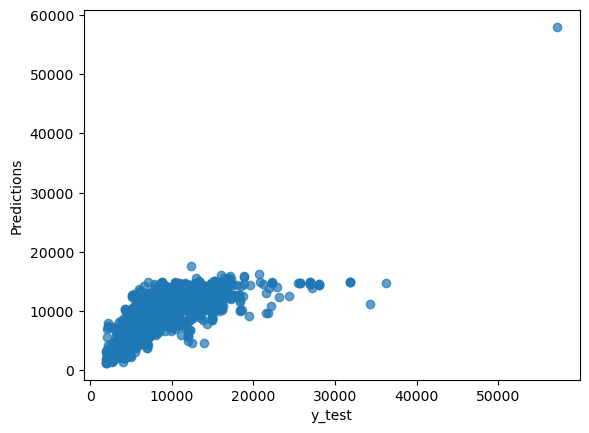

In [20]:
plt.scatter(y_test,prediction, alpha=0.7)
plt.xlabel('y_test')
plt.ylabel('Predictions');